### Problem 1 | K-NN Classifier
Given the MAGIC gamma telescope dataset. This dataset is generated to simulate registration of high
energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging
technique. The dataset consists of two classes: gammas (signal) and hadrons (background). There are
12332 gamma events and 6688 hadron events

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

In [32]:
data = pd.read_csv("magic04.data", header=None)

# print(data.head())

class_distribution = data.iloc[:, -1].value_counts()
print(class_distribution)



g    12332
h     6688
Name: 10, dtype: int64


Note that samples are found to be unbalanced in the class distribution, therefore we'll be putting aside extra readings

In [30]:

hadrons_data = data[data.iloc[:, -1] == 'h']
gamma_data = data[data.iloc[:, -1] == 'g'].sample(n=hadrons_data.shape[0], random_state=1)

combined_data = pd.concat([gamma_data, hadrons_data], ignore_index=True)


### Splitting Data:
70% training, 15% validation, 15% test

In [23]:
training_data, test_val_data = train_test_split(combined_data, test_size=0.3, random_state=1)
validation_data, test_data = train_test_split(test_val_data, test_size=0.5, random_state=1)

x_training_data = training_data.iloc[:, :-1]
y_training_data = training_data.iloc[:, -1]
x_validation_data = validation_data.iloc[:, :-1]
y_validation_data = validation_data.iloc[:, -1]
x_test_data = test_data.iloc[:, :-1]
y_test_data = test_data.iloc[:, -1]


### Standardizing Features:
since given features have different ranges

In [24]:
scaler = StandardScaler()
x_training_data = scaler.fit_transform(x_training_data)
x_validation_data = scaler.transform(x_validation_data)
x_test_data = scaler.transform(x_test_data)


### Training the K-NN Classifier model

In [33]:
k_metrics = {}

for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_training_data, y_training_data)
    y_predictions = knn.predict(x_validation_data)

    # Performance
    accuracy = accuracy_score(y_validation_data, y_predictions)
    precision = precision_score(y_validation_data, y_predictions, pos_label='g')
    recall = recall_score(y_validation_data, y_predictions, pos_label='g')
    f1 = f1_score(y_validation_data, y_predictions, pos_label='g')
    conf_matrix = confusion_matrix(y_validation_data, y_predictions)

    k_metrics[k] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }


### Finding the best K value

In [34]:
best_k = max(k_metrics, key=lambda x: (k_metrics[x]['f1_score'], k_metrics[x]['accuracy']))
best_metrics = k_metrics[best_k]

print(f"\nBest k value based on F1-score (and accuracy if F1-scores are equal): k={best_k}")
print(f"Accuracy={best_metrics['accuracy']:.2f}")
print(f"Precision={best_metrics['precision']:.2f}")
print(f"Recall={best_metrics['recall']:.2f}")
print(f"F1 Score={best_metrics['f1_score']:.2f}")
print(f"Confusion Matrix:\n{best_metrics['confusion_matrix']}")


Best k value based on F1-score (and accuracy if F1-scores are equal): k=13
Accuracy=0.83
Precision=0.79
Recall=0.90
F1 Score=0.84
Confusion Matrix:
[[925 108]
 [241 732]]


### Retraining model with train/validation data combination

In [35]:
x_train_validation = pd.concat([pd.DataFrame(x_training_data), pd.DataFrame(x_validation_data)], ignore_index=True)
y_train_validation = pd.concat([y_training_data, y_validation_data], ignore_index=True)

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(x_train_validation, y_train_validation)


KNeighborsClassifier(n_neighbors=13)

### Final Model Evaluation (test data)

In [36]:
y_test_predictions = best_knn.predict(x_test_data)
test_accuracy = accuracy_score(y_test_data, y_test_predictions)
test_precision = precision_score(y_test_data, y_test_predictions, pos_label='g')
test_recall = recall_score(y_test_data, y_test_predictions, pos_label='g')
test_f1 = f1_score(y_test_data, y_test_predictions, pos_label='g')
test_conf_matrix = confusion_matrix(y_test_data, y_test_predictions)

print("\nTEST DATA METRICS")
print(f"Accuracy={test_accuracy:.2f}")
print(f"Precision={test_precision:.2f}")
print(f"Recall={test_recall:.2f}")
print(f"F1 Score={test_f1:.2f}")
print(f"Confusion Matrix:\n{test_conf_matrix}")


TEST DATA METRICS
Accuracy=0.81
Precision=0.76
Recall=0.89
F1 Score=0.82
Confusion Matrix:
[[873 103]
 [280 751]]


### Some plots that may help visualize the model/ output

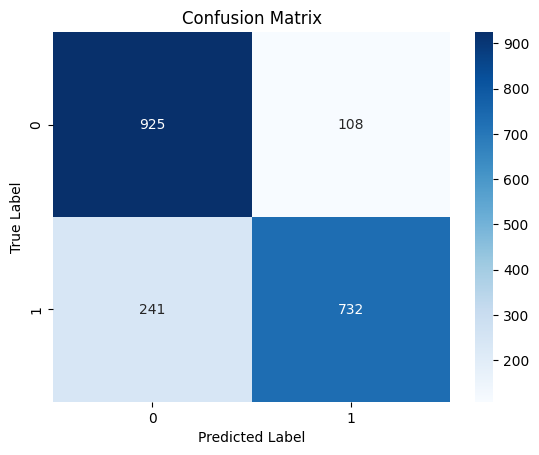

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(best_metrics['confusion_matrix'], annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


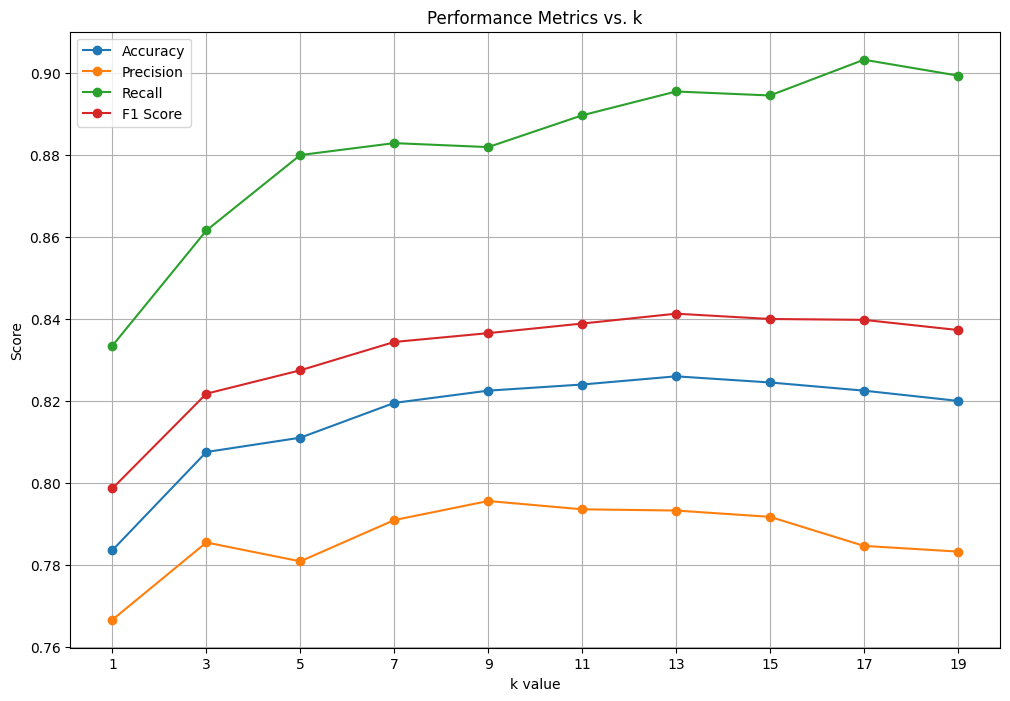

In [38]:
# Store metrics for each k
k_values = list(k_metrics.keys())
accuracies = [k_metrics[k]['accuracy'] for k in k_values]
precisions = [k_metrics[k]['precision'] for k in k_values]
recalls = [k_metrics[k]['recall'] for k in k_values]
f1_scores = [k_metrics[k]['f1_score'] for k in k_values]

plt.figure(figsize=(12, 8))
plt.plot(k_values, accuracies, marker='o', label='Accuracy')
plt.plot(k_values, precisions, marker='o', label='Precision')
plt.plot(k_values, recalls, marker='o', label='Recall')
plt.plot(k_values, f1_scores, marker='o', label='F1 Score')
plt.title('Performance Metrics vs. k')
plt.xlabel('k value')
plt.ylabel('Score')
plt.xticks(k_values)
plt.grid()
plt.legend()
plt.show()


### Conclusion:
As previously mentioned, K=13 was chosen to be the best K value for this model